In [1]:
import pandas as pd
import numpy as np
import healpy as hp

from astropy.cosmology import Planck15
from astropy.table import Table
import astropy 
from ligo.skymap.io import fits
from ligo.skymap.postprocess import find_greedy_credible_levels

import os
from os import listdir
from os.path import isfile, join

import sys

H0GLOB=67.9 #69
Om0GLOB=0.3
Xi0Glob =1.
cosmoglob = Planck15
clight = 2.99792458* 10**5#km/s


        Use get instead. [ligo.skymap.postprocess.cosmology]


In [2]:
def get_ename(fname, verbose=True):

        if len(fname.split('/')[-1].split('_')) <= 2:    #Same as before since certain names contain a "_"
            event_name = fname.split('/')[-1].split('_')[0]
        elif len(fname.split('/')[-1].split('_')) > 2:
            event_name = fname.split('/')[-1].split('_')[0]+'_'+fname.split('/')[-1].split('_')[1]
        else:
            raise ValueError('Could not set event name. Got fname= %s'%fname)
        if verbose:
            print('-- %s' %event_name)
        return event_name
    
def find_ra_dec(nside, pix):
        '''
        input:  pixel ra dec in degrees
        output: (ra, dec) of pixel center in degrees, with nside given by that of the skymap 
        '''
        theta, phi =find_theta_phi(nside,pix)
        ra, dec = ra_dec_from_th_phi(theta, phi)
        return ra, dec    
    
def ra_dec_from_th_phi(theta, phi):
        ra = np.rad2deg(phi)
        dec = np.rad2deg(0.5 * np.pi - theta)
        return ra, dec
    
def find_theta_phi(nside, pix):
        '''
        input:  pixel
        output: (theta, phi)of pixel center in rad, with nside given by that of the skymap 
        '''
        return hp.pix2ang(nside, pix, nest=True)
    
def _read_O3( fname, convert_nested=True):
        
        skymap, metadata = fits.read_sky_map(fname, nest=None, distances=True) #Read the skymap
        event_name = get_ename(fname, verbose=True)
        print('Event: %s' %event_name)
        if (convert_nested) & (metadata['nest']): #If one wants RING ordering (the one of O2 data afaik) just has to set "convert_nested" to True
            p_posterior = hp.reorder(skymap[0],n2r=True)
            mu = hp.reorder(skymap[1],n2r=True)
            sigma = hp.reorder(skymap[2],n2r=True)
            posteriorNorm = hp.reorder(skymap[3],n2r=True)
            print('convertito da nested a ring')
        else:
            p_posterior= skymap[0]
            mu= skymap[1]
            sigma = skymap[2]
            posteriorNorm= skymap[3]        
        npix = len(p_posterior)
        nside=hp.npix2nside(npix)
        theta,phi=find_theta_phi(nside,np.argmax(p_posterior))
        #print('Theta={}, Phi={}'.format(theta, phi))
        #ra, dec=find_ra_dec(nside,np.argmax(p_posterior))
        #print('Right Ascension={}, Declination={}'.format(ra, dec))
        #print(metadata)
        #dl=metadata['distmean']
        #std=metadata['diststd']
        #z=cosmoglob.H(0).value*dl/clight
        #sigz=cosmoglob.H(0).value*std/clight
        #print('dL={}Mpc, std={}Mpc'.format(dl,std))
        #print('z={}, delta_z={}'.format(z,sigz))
        #print('\n')
        head = None

In [3]:
#GWdata path
GW_data_path='/home/rciancarella/DarkSirensStat/data/GW/O3/'
os.chdir(GW_data_path)
#all_event=os.listdir()


  # Function to exploit, find how to localise an event and produce a proxy one. 
   def _read_O3(self, fname, convert_nested=True):
        
   skymap, metadata = fits.read_sky_map(fname, nest=None, distances=True) #Read the skymap
        self.event_name = get_ename(fname, verbose=self.verbose)
        if self.verbose:
                print('\nEvent: %s' %self.event_name)
                #Raul: prints for control
                print('Delta=%s. If delta=1, normal run '%delta)
        if (convert_nested) & (metadata['nest']): #If one wants RING ordering (the one of O2 data afaik) just has to set "convert_nested" to True
            self.p_posterior = hp.reorder(skymap[0],n2r=True)
            self.mu = hp.reorder(skymap[1],n2r=True)
            self.sigma = hp.reorder(skymap[2],n2r=True)*delta
            self.posteriorNorm = hp.reorder(skymap[3],n2r=True)
        else:
            self.p_posterior= skymap[0]
            self.mu= skymap[1]
            self.sigma = skymap[2]*delta
            self.posteriorNorm= skymap[3]    

In [4]:
#Some files to look at 
filenames=['GW190412_PublicationSamples.fits','GW190814_PublicationSamples.fits',
          'GW190924_021846_PublicationSamples.fits','GW190527_092055_PublicationSamples.fits',
         'GW190421_213856_PublicationSamples.fits','GW190708_232457_PublicationSamples.fits',
         'GW190915_235702_PublicationSamples.fits']
########################## THIS GIVE US SOME INFO ######################################
#for name in filenames:
#    _read_O3(name)
########################################################################################
fname ='GW190814_PublicationSamples.fits'
skymap, metadata = fits.read_sky_map(fname, nest=None, distances=True)

In [5]:
p_posterior= skymap[0]
mu= skymap[1]
sigma = skymap[2]
posteriorNorm= skymap[3]        
npix = len(p_posterior)
nside=hp.npix2nside(npix)
theta,phi=find_theta_phi(nside,np.argmax(p_posterior))
ra, dec=find_ra_dec(nside,np.argmax(p_posterior))
#10 deg^2 =0.000 304 617 419 786 71 sr
radius_deg= np.sqrt(10/np.pi)
sigma_deg=radius_deg/2.8
circle_deg=6*sigma_deg

In [6]:
my_theta,my_phi=hp.pix2ang(nside, np.argmax(p_posterior), nest=True)
vec = hp.ang2vec(my_theta, my_phi)
my_maxpix=hp.ang2pix(nside, my_theta, my_phi,nest=True)
maxpix=np.argmax(p_posterior)
print(maxpix,my_maxpix)

4266225 4266225


In [7]:
print(vec)

[ 0.88506156  0.19946041 -0.42057292]


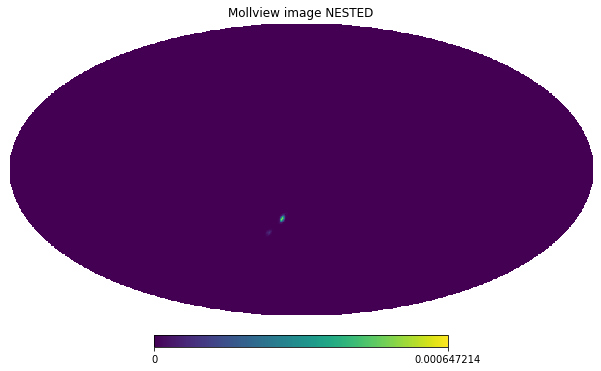

In [8]:
hp.mollview(p_posterior, title="Mollview image NESTED",nest=True)

In [9]:
credible_levels = find_greedy_credible_levels(p_posterior)
Ligo_Area_99_deg=np.sum(credible_levels <= 0.99) * hp.nside2pixarea(nside, degrees=True)
Ligo_Area_90_deg=np.sum(credible_levels <= 0.9) * hp.nside2pixarea(nside, degrees=True)
print('Ligo area_deg 99% is {}\nLigo area_deg 90% is {} '.format(Ligo_Area_99_deg,Ligo_Area_90_deg))

Ligo area_deg 99% is 48.40035970411115
Ligo area_deg 90% is 18.838208146028766 


In [10]:
ipix_disc = hp.query_disc(nside=nside, vec=vec, radius=np.radians(circle_deg), nest=True)
ipix_90 = hp.query_disc(nside=nside, vec=vec, radius=np.radians(radius_deg), nest=True)
m =np.zeros(len(p_posterior))
m[ipix_disc] = 1/len(ipix_disc)
#hp.mollview(m, title="Mollview image NESTED",nest=True)

In [11]:
Mock_Area_deg=len(ipix_disc) * hp.nside2pixarea(nside, degrees=True)
Mock_Area_90_deg=len(ipix_90) *hp.nside2pixarea(nside, degrees=True)
print('99.9999% area is {} squared deg\n90% area is {} squared deg'.format(Mock_Area_deg,Mock_Area_90_deg))

99.9999% area is 45.862807823668014 squared deg
90% area is 10.015789398906698 squared deg


In [12]:
'''
https://emfollow.docs.ligo.org/userguide/tutorial/skymaps.html(for ref on skymap)

Now we need to rescale the probability. We set the prob=0 ouside the circle
We assume that the renormalization is constant.
We crate a mask with our circle. Outside the mask p_posterior=0, the renormalization
constan alpha, is therefore 1/sum(p_posterior()). This ensure unitarity. 

If this works, than we will use a 2D Gaussian distribution for the probability

'''


'\nhttps://emfollow.docs.ligo.org/userguide/tutorial/skymaps.html(for ref on skymap)\n\nNow we need to rescale the probability. We set the prob=0 ouside the circle\nWe assume that the renormalization is constant.\nWe crate a mask with our circle. Outside the mask p_posterior=0, the renormalization\nconstan alpha, is therefore 1/sum(p_posterior()). This ensure unitarity. \n\nIf this works, than we will use a 2D Gaussian distribution for the probability\n\n'

In [13]:
saved_prob=np.zeros(len(p_posterior))
saved_prob[ipix_disc]=p_posterior[ipix_disc]
prob_to_write=np.zeros(len(p_posterior))
alpha=1/np.sum(saved_prob)
prob_to_write[ipix_disc]=alpha*saved_prob[ipix_disc]

In [14]:
print(np.sum(prob_to_write))

0.9999999999999999


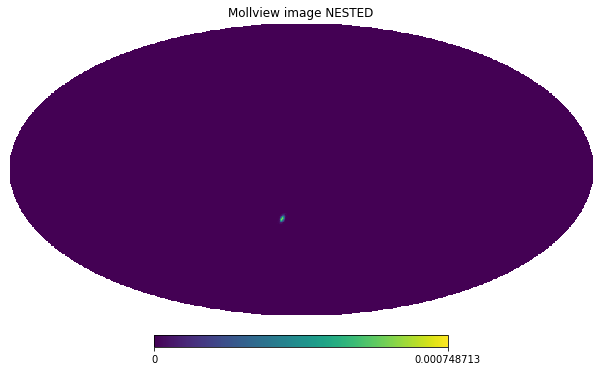

In [15]:
hp.mollview(prob_to_write, title="Mollview image NESTED",nest=True)

In [32]:
#my_sky_tosave=(prob_to_write,skymap[1],sigma,posteriorNorm)
#my_sky_tosave=np.array([prob_to_write,mu,sigma,posteriorNorm])
#dat=Table([prob_to_write,mu,sigma,posteriorNorm],
#          names=('PROB','DISTMU','DISTSIGMA','DISTNORM'))
#dat.write('Amap.fits',format='fits',overwrite=True)
#fits.write_sky_map('Amap.fits',dat, nest=True)

AttributeError: module 'numpy' has no attribute 'dprob_to_write'

In [17]:
#check result

In [18]:
#my_data,my_meta=fits.read_sky_map("Amap.fits",nest=None, distances=True)
#print(my_meta)

In [19]:
#hp.mollview(my_data[0], title="Mollview image NESTED",nest=True)

In [20]:
#print(my_meta)

In [21]:
#_read_O3('Amap.fits')

In [22]:
sigma_theta=sigma_deg/2
sigma_phi=sigma_deg/2
def uncorr_gauss(x,y,mux=my_theta,muy=my_phi,sigx=sigma_theta,sigy=sigma_phi):
    #correlation is 0 so is a multiplication of two gaussians
    xfactor=((x-mux)/sigx)**2
    yfactor=((y-muy)/sigy)**2
    #norm=2*np.pi*sigx*sigy
    ret=np.exp(-(1/2)*(xfactor+yfactor))#/norm
    return ret

In [23]:
gaussmap =np.zeros(len(p_posterior))

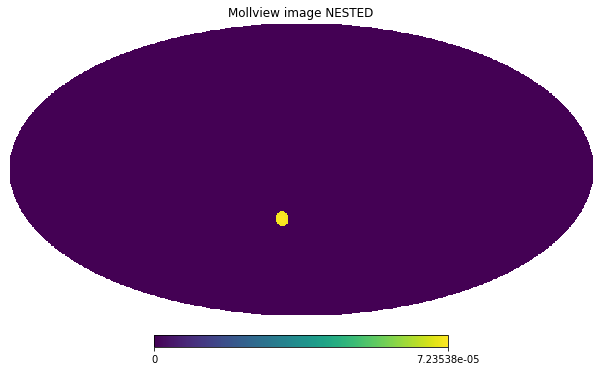

In [29]:
for i in ipix_disc:
    theta,phi=hp.pix2ang(nside,i, nest=True)
    gaussmap[i]=uncorr_gauss(theta,phi)
#gaussmap[ipix_disc] = 1/len(ipix_disc)
gaussmap[ipix_disc]=gaussmap[ipix_disc]/np.sum(gaussmap)
hp.mollview(gaussmap, title="Mollview image NESTED",nest=True)

In [30]:
print(gaussmap[gaussmap>0])

[7.07858959e-05 7.07973840e-05 7.08006666e-05 ... 7.04862558e-05
 7.05236212e-05 7.04834010e-05]


In [31]:
print(np.max(p_posterior))
print(np.max(gaussmap))

0.0006588459413258549
7.235565657340812e-05


In [27]:
np.sum(gaussmap)

1.0

In [28]:
print(ipix_disc)

[4260175 4260179 4260180 ... 9158652 9158654 9158655]


In [34]:
#my_sky_tosave=(gaussmap,mu,sigma,posteriorNorm)
my_sky_tosave=np.array([gaussmap,mu,sigma,posteriorNorm])
dat=Table([gaussmap,mu,sigma,posteriorNorm],
          names=('PROB','DISTMU','DISTSIGMA','DISTNORM'))
#dat.write('Amap.fits',format='fits',overwrite=True)
fits.write_sky_map('GaussAmap.fits',dat, nest=True)